In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# set traditional Chinese display
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

In [139]:
# Load the datasets
data = pd.read_csv('../output/Week7/convert_shot.csv', encoding='utf-8')
rally_data = pd.read_csv('../dataset/Single_Badminton_0108/rally_0108.csv', encoding='utf-8')
set_data = pd.read_csv('../dataset/Single_Badminton_0108/set_0108.csv', encoding='utf-8')
match_data = pd.read_csv('../dataset/Single_Badminton_0108/match_0108.csv', encoding='utf-8')

# Randomly select 6 win match and 1 lose match
# Only record match_id
win_match = match_data[match_data['match_winner'] == 1]['match_id'].sample(6)
lose_match = match_data[match_data['match_loser'] == 1]['match_id'].sample(1)

win_match = set_data[set_data['match_id'].isin(win_match)]['set_id']
lose_match = set_data[set_data['match_id'].isin(lose_match)]['set_id']

win_match = rally_data[rally_data['set_id'].isin(win_match)]['rally_id']
lose_match = rally_data[rally_data['set_id'].isin(lose_match)]['rally_id']
win_match = list(win_match)
lose_match = list(lose_match)

data = data[(data['rally_id'].isin(win_match + lose_match))]

In [ ]:
# Filter players
players_filtered = data[data['rally_id'].isin(win_match) | data['rally_id'].isin(lose_match)]

# Get the maximum shot number for each rally
max_shots_per_rally = players_filtered.groupby('rally_id')['shot_number'].max().reset_index()
max_shots_per_rally.columns = ['rally_id', 'max_shot_number']

# Merge the max_shots_per_rally back to the players_filtered
players_filtered = players_filtered.merge(max_shots_per_rally, on='rally_id', how='left')

# Initialize the list to collect rows
rows_win = []
rows_lose = []

# Initialize previous shot variable
prev = "未知球種"

# Iterate over the filtered DataFrame rows
for idx, row in players_filtered.iterrows():
    if row['shot_number'] == 1:
        continue

    # Check ball type
    if row['shot_type'] in ['擋小球', '勾球', '放小球', '小平球']:
        row['shot_type'] = '網前小球'
    elif row['shot_type'] == '防守回挑':
        row['shot_type'] = '挑球'
    elif row['shot_type'] in ['防守回抽', '後場抽平球']:
        row['shot_type'] = '平球'
    elif row['shot_type'] == '過度切球':
        row['shot_type'] = '切球'
    elif row['shot_type'] in ['推球', '撲球']:
        row['shot_type'] = '推撲球'

    if row['shot_player'] != 1:
        prev = row["shot_type"]
        continue

    newrow = {
        "rally_id": row["rally_id"],
        "shot_id": row["shot_id"],
        "up_court": 0,
        "score": 0,
        "hit_x": None,
        "hit_y": None,
        "shot_type": row["shot_type"],
        "挑球": 0,
        "殺球": 0,
        "平球": 0,
        "網前小球": 0,
        "切球": 0,
        "推撲球": 0,
        "長球": 0,
        "cluster": None
    }
    # print(row)
    if row['shot_player'] == 1:
        newrow["hit_x"] = row['shot_hit_position_x']
        newrow["hit_y"] = row['shot_hit_position_y']

    if newrow["hit_y"] > 67:
        newrow["up_court"] = 1
        newrow["hit_x"] = 61 - newrow["hit_x"]
        newrow["hit_y"] = 134 - newrow["hit_y"]

    if newrow["hit_y"] > 67:
        newrow["up_court"] = 1
        newrow["hit_x"] = 61 - newrow["hit_x"]
        newrow["hit_y"] = 134 - newrow["hit_y"]

    
    # Ensure only valid ball types are added
    newrow["shot_type"] = row["shot_type"]
    if row['rally_id'] in lose_match:
        print(newrow)
    if prev == "未知球種" or row["shot_type"] == "未知球種":
        continue
    newrow[f'{prev}'] = 1

    # Check if the current shot is one of the last two shots in the rally
    if row['shot_number'] >= row['max_shot_number'] - 1:
        rally_winner = rally_data[rally_data['rally_id'] == row['rally_id']]['rally_score_player'].values
        if rally_winner == 1:
            newrow["score"] = 1
        else:
            newrow["score"] = -1
    
    if row['rally_id'] in win_match:
        rows_win.append(newrow)
    else:
        rows_lose.append(newrow)


# Create a new DataFrame from the list of rows
win_df = pd.DataFrame(rows_win)
lose_df = pd.DataFrame(rows_lose)

# Define the desired column order
column_order = [
    "rally_id", "shot_id", "up_court", "hit_x", "hit_y",
    "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球", "shot_type", "score", "cluster"
]

# Reorder the columns
win_df = win_df[column_order]
lose_df = lose_df[column_order]

win_df.to_csv('../output/Week9_single/processed_shot_win.csv', index=False, encoding='utf-8')
lose_df.to_csv('../output/Week9_single/processed_shot_lose.csv', index=False, encoding='utf-8')

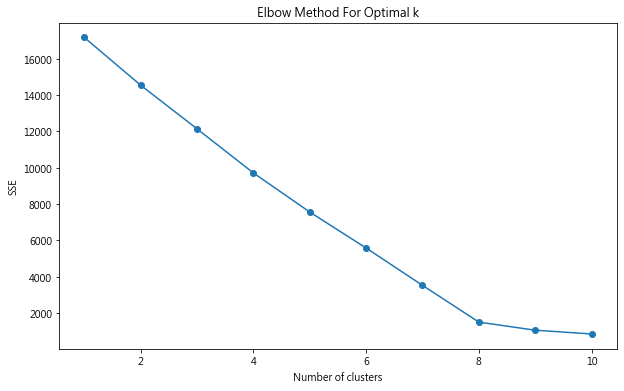

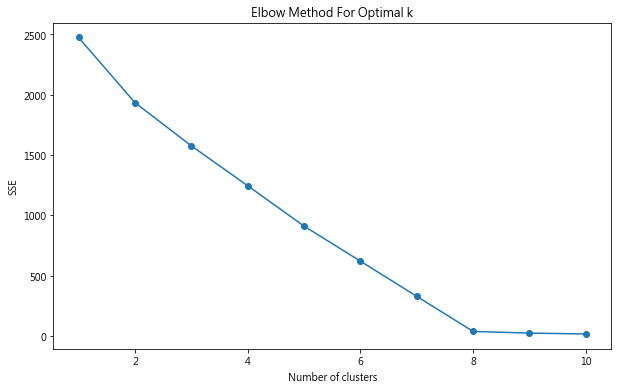

In [143]:
data_win = pd.read_csv('../output/Week9_single/processed_shot_win.csv')
data_lose = pd.read_csv('../output/Week9_single/processed_shot_lose.csv')

name = ['win', 'lose']
for Name in name:
    if Name == 'win':
        data = data_win
    else:
        data = data_lose
    features = data[["hit_x", "hit_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]]
    # standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    

    # use elbow method to find the optimal k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        sse.append(kmeans.inertia_)

    # plot the elbow method
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method For Optimal k') 
    plt.savefig(f'../output/Week9_single/elbow_plot_{Name}.png')
    plt.show()

In [ ]:
# clustering
n = 8  # Best n from elbow method
kmeans = KMeans(n_clusters=n)
features = data_win[["hit_x", "hit_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]]
data_win['cluster'] = kmeans.fit_predict(features)

In [ ]:
# clustering
n = 8  # Best n from elbow method
kmeans = KMeans(n_clusters=n)
features = data_lose[["hit_x", "hit_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]]
data_lose['cluster'] = kmeans.fit_predict(features)

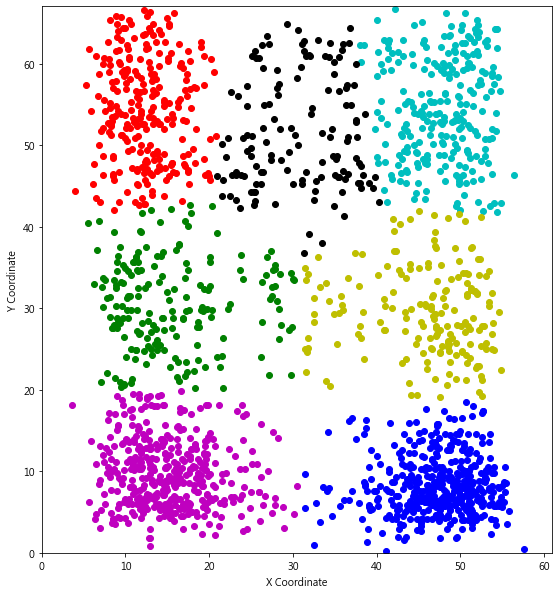

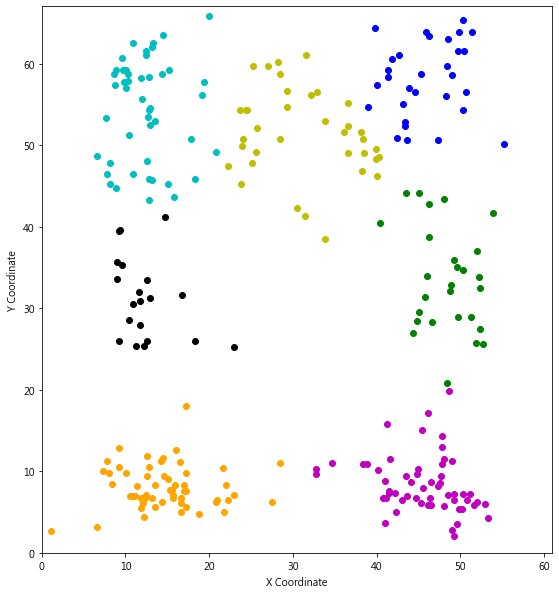

In [153]:
# plot the clustering result
colors = ['b', 'r', 'orange', 'c', 'm', 'y', 'k', 'g']

for Name in name:
    if Name == 'win':
        data = data_win
    else:
        data = data_lose
    for cluster in range(0, n):
        plt.figure(figsize=(9.15, 10.05))
        
        cluster_data = data[data['cluster'] == cluster]
        if len(cluster_data) > 100:
            sample_cluster_data = cluster_data.sample(n=100, random_state=1)
        else:
            sample_cluster_data = cluster_data
        
        plt.scatter(sample_cluster_data['hit_x'], sample_cluster_data['hit_y'], color='r', label=f'Cluster {cluster} - Hit player')
        
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.xlim(0, 61) 
        plt.ylim(0, 67) 
        plt.savefig(f'../output/Week9_single/{Name}_cluster_{cluster}_positions.jpg')
        plt.close()
    # plot all clustering results in one figure
    plt.figure(figsize=(9.15, 10.05))
    for cluster in range(n):
        cluster_data = data[data['cluster'] == cluster]
        plt.scatter(cluster_data['hit_x'], cluster_data['hit_y'], color=colors[cluster % len(colors)], label=f'Cluster {cluster} - Hit player')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 61) 
    plt.ylim(0, 67)
    # plt.legend()
    plt.savefig(f'../output/Week9_single/{Name}_clusters_positions.jpg')
    plt.show()
    data_win.to_csv('../output/Week9_single/win_clustered_shot.csv', index=False, encoding='utf-8')
    data_lose.to_csv('../output/Week9_single/lose_clustered_shot.csv', index=False, encoding='utf-8')

In [161]:

# Define the ball types
ball_types = ["挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]

for Name in name:
    data = pd.read_csv(f'../output/Week9_single/{Name}_clustered_shot.csv')
    # Transform one-hot encoding to ball type strings for the opponent's shots
    data['opponent_ball_type'] = data[ball_types].idxmax(axis=1)
    print(Name)
    for cluster in range(n):
        clustered_data = data[data['cluster'] == cluster]
        matrix = pd.crosstab(clustered_data['opponent_ball_type'], clustered_data['shot_type'], dropna=False)
        matrix = matrix.reindex(index=ball_types, columns=ball_types, fill_value=0)

        # Calculate the percentage matrix
        matrix_percentage = matrix / matrix.values.sum() * 100

        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=ball_types, yticklabels=ball_types)
        plt.xlabel("Our hit ball type")
        plt.ylabel("Opponent's hit ball type")
        plt.yticks(rotation=45)
        plt.title(f'Confusion Matrix (Percentage) for Cluster {cluster}')
        plt.savefig(f'../output/Week9_single/{Name}_cluster_{cluster}_confusion_matrix.jpg')
        plt.close()
        # Calculate winning rate and losing rate
        print("cluster",cluster, "size =",clustered_data.shape[0], end = ' ')
        print(f"scoring ratio: {clustered_data['score'][clustered_data['score'] == 1].count() / clustered_data['shot_id'].count():.3f}", end=' ')
        print(f"lose score ratio: {clustered_data['score'][clustered_data['score'] == -1].count() / clustered_data['shot_id'].count():.3f}")


win
cluster 0 size = 438 scoring ratio: 0.123 lose score ratio: 0.119
cluster 1 size = 258 scoring ratio: 0.171 lose score ratio: 0.116
cluster 2 size = 24 scoring ratio: 0.125 lose score ratio: 0.208
cluster 3 size = 254 scoring ratio: 0.161 lose score ratio: 0.146
cluster 4 size = 418 scoring ratio: 0.120 lose score ratio: 0.134
cluster 5 size = 186 scoring ratio: 0.118 lose score ratio: 0.097
cluster 6 size = 136 scoring ratio: 0.132 lose score ratio: 0.081
cluster 7 size = 194 scoring ratio: 0.098 lose score ratio: 0.119
lose
cluster 0 size = 30 scoring ratio: 0.200 lose score ratio: 0.300
cluster 1 size = 3 scoring ratio: 0.000 lose score ratio: 0.333
cluster 2 size = 57 scoring ratio: 0.123 lose score ratio: 0.105
cluster 3 size = 46 scoring ratio: 0.109 lose score ratio: 0.087
cluster 4 size = 56 scoring ratio: 0.089 lose score ratio: 0.196
cluster 5 size = 36 scoring ratio: 0.028 lose score ratio: 0.056
cluster 6 size = 20 scoring ratio: 0.100 lose score ratio: 0.200
cluster 7 